In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from segmentation_models_pytorch import Unet

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 128
learning_rate = .00002
num_epochs = 100
loss_weights = (1.0, 1.0, 1.0, 1.0)

In [3]:
dataset = torch.load("dataset_scaled.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

class MultiTaskV3_1(nn.Module):
    def __init__(self):
        super().__init__()

        self.cloud_mask_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=1,
        )

        self.cloud_phase_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )
        self.cod_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )
        self.cps_net = Unet(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )

        self.norm0 = nn.BatchNorm2d(num_features=64)        
        self.conv0 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)


    def forward(self, x):
        x = F.relu(self.norm0(self.conv0(x)))
        cloud_mask_pred = self.cloud_mask_net(x)
        cloud_phase_pred = self.cloud_phase_net(x)
        cod_pred = self.cod_net(x)
        cps_pred = self.cps_net(x)

        cloud_phase_pred = torch.cat([cloud_mask_pred, cloud_phase_pred], dim=1)
        cod_pred = torch.cat([cloud_mask_pred, cod_pred], dim=1)
        cps_pred = torch.cat([cloud_mask_pred, cps_pred], dim=1)

        cloud_phase_pred = self.conv1(cloud_phase_pred)
        cod_pred = F.relu(self.conv2(cod_pred))
        cps_pred = F.relu(self.conv3(cps_pred))

        return cloud_mask_pred, cloud_phase_pred, cod_pred, cps_pred

In [6]:
#FINAL SETUP

dev_str = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev_str)
model = MultiTaskV3_1().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler(device = device)

def unpack_labels(labels):
    return (
        labels[:, 0:1, :, :],             # cloud_mask → [B, H, W]
        labels[:, 1, :, :].long(),        # cloud_phase → [B, H, W]
        labels[:, 2:3, :, :],             # cod → [B, 1, H, W]
        labels[:, 3:4, :, :]              # cps → [B, 1, H, W]
    )


train_mask_losses, train_phase_losses, train_cod_losses, train_cps_losses, train_all_losses = [], [], [], [], []
val_mask_losses, val_phase_losses, val_cod_losses, val_cps_losses, val_all_losses = [], [], [], [], []

train_mask_acc, train_phase_acc, train_cod_r2, train_cps_r2 = [], [], [], []
val_mask_acc, val_phase_acc, val_cod_r2, val_cps_r2 = [], [], [], []

In [7]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader, loss_weights=(1,1,1,1)):
    model.train()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        optimizer.zero_grad()
        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        with autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            

        # Update model
        scaler.scale(total_batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(train_loader),
        'loss_mask': total_loss_mask / len(train_loader),
        'loss_phase': total_loss_phase / len(train_loader),
        'loss_cod': total_loss_cod / len(train_loader),
        'loss_cps': total_loss_cps / len(train_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }



def eval(model, val_loader, loss_weights=(1,1,1,1)):
    model.eval()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in (val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        
        with torch.no_grad(), autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            
        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(val_loader),
        'loss_mask': total_loss_mask / len(val_loader),
        'loss_phase': total_loss_phase / len(val_loader),
        'loss_cod': total_loss_cod / len(val_loader),
        'loss_cps': total_loss_cps / len(val_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }

In [8]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_results = train(model, train_loader, loss_weights = loss_weights)
    val_results = eval(model, val_loader, loss_weights = loss_weights)
    
    train_mask_losses.append(train_results['loss_mask'])
    train_phase_losses.append(train_results['loss_phase'])
    train_cod_losses.append(train_results['loss_cod'])
    train_cps_losses.append(train_results['loss_cps'])
    train_all_losses.append(train_results['loss_total'])

    train_mask_acc.append(train_results['acc_mask'])
    train_phase_acc.append(train_results['acc_phase'])
    train_cod_r2.append(train_results['r2_cod'])
    train_cps_r2.append(train_results['r2_cps'])

    val_mask_losses.append(val_results['loss_mask'])
    val_phase_losses.append(val_results['loss_phase'])
    val_cod_losses.append(val_results['loss_cod'])
    val_cps_losses.append(val_results['loss_cps'])
    val_all_losses.append(val_results['loss_total'])

    val_mask_acc.append(val_results['acc_mask'])
    val_phase_acc.append(val_results['acc_phase'])
    val_cod_r2.append(val_results['r2_cod'])
    val_cps_r2.append(val_results['r2_cps'])

    print(f"Epoch: {e} | Train Loss: {train_results['loss_total']:.4f} | Val Loss: {val_results['loss_total']:.4f} | Val Mask: {val_results['acc_mask']:.4f} | Val Phase: {val_results['acc_phase']:.4f} | Val Cod: {val_results['r2_cod']:.4f} | Val Cps: {val_results['r2_cps']:.4f}")
    

100%|██████████| 94/94 [00:30<00:00,  3.08it/s]


Epoch: 1 | Train Loss: 11.6652 | Val Loss: 9.7343 | Val Mask: 0.6031 | Val Phase: 0.6061 | Val Cod: -0.2917 | Val Cps: -1.7170


100%|██████████| 94/94 [00:27<00:00,  3.40it/s]


Epoch: 2 | Train Loss: 8.7482 | Val Loss: 7.4432 | Val Mask: 0.6208 | Val Phase: 0.7431 | Val Cod: 0.1126 | Val Cps: -1.0607


100%|██████████| 94/94 [00:27<00:00,  3.44it/s]


Epoch: 3 | Train Loss: 6.7332 | Val Loss: 5.7571 | Val Mask: 0.6640 | Val Phase: 0.7824 | Val Cod: 0.4905 | Val Cps: -0.6318


100%|██████████| 94/94 [00:26<00:00,  3.48it/s]


Epoch: 4 | Train Loss: 5.1158 | Val Loss: 4.3494 | Val Mask: 0.7692 | Val Phase: 0.8005 | Val Cod: 0.6098 | Val Cps: -0.1787


100%|██████████| 94/94 [00:26<00:00,  3.48it/s]


Epoch: 5 | Train Loss: 3.8693 | Val Loss: 3.6228 | Val Mask: 0.8758 | Val Phase: 0.8088 | Val Cod: 0.6420 | Val Cps: 0.0625


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 6 | Train Loss: 2.8811 | Val Loss: 2.5467 | Val Mask: 0.9090 | Val Phase: 0.8245 | Val Cod: 0.6655 | Val Cps: 0.4677


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 7 | Train Loss: 2.2925 | Val Loss: 2.1443 | Val Mask: 0.9312 | Val Phase: 0.8272 | Val Cod: 0.6759 | Val Cps: 0.5942


100%|██████████| 94/94 [00:28<00:00,  3.30it/s]


Epoch: 8 | Train Loss: 2.0179 | Val Loss: 2.0115 | Val Mask: 0.9303 | Val Phase: 0.8291 | Val Cod: 0.6767 | Val Cps: 0.6374


100%|██████████| 94/94 [00:27<00:00,  3.37it/s]


Epoch: 9 | Train Loss: 1.8837 | Val Loss: 1.9056 | Val Mask: 0.9406 | Val Phase: 0.8339 | Val Cod: 0.6853 | Val Cps: 0.6534


100%|██████████| 94/94 [00:27<00:00,  3.38it/s]


Epoch: 10 | Train Loss: 1.7779 | Val Loss: 1.8172 | Val Mask: 0.9417 | Val Phase: 0.8435 | Val Cod: 0.6921 | Val Cps: 0.6663


100%|██████████| 94/94 [00:28<00:00,  3.36it/s]


Epoch: 11 | Train Loss: 1.7070 | Val Loss: 1.7648 | Val Mask: 0.9468 | Val Phase: 0.8430 | Val Cod: 0.7002 | Val Cps: 0.6740


100%|██████████| 94/94 [00:27<00:00,  3.40it/s]


Epoch: 12 | Train Loss: 1.6505 | Val Loss: 1.7406 | Val Mask: 0.9474 | Val Phase: 0.8455 | Val Cod: 0.6996 | Val Cps: 0.6752


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 13 | Train Loss: 1.6031 | Val Loss: 1.6781 | Val Mask: 0.9494 | Val Phase: 0.8494 | Val Cod: 0.7064 | Val Cps: 0.6868


100%|██████████| 94/94 [00:26<00:00,  3.52it/s]


Epoch: 14 | Train Loss: 1.5495 | Val Loss: 1.6553 | Val Mask: 0.9484 | Val Phase: 0.8521 | Val Cod: 0.7051 | Val Cps: 0.6906


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 15 | Train Loss: 1.5144 | Val Loss: 1.6131 | Val Mask: 0.9515 | Val Phase: 0.8544 | Val Cod: 0.7150 | Val Cps: 0.6940


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 16 | Train Loss: 1.4647 | Val Loss: 1.5836 | Val Mask: 0.9535 | Val Phase: 0.8569 | Val Cod: 0.7197 | Val Cps: 0.6970


100%|██████████| 94/94 [00:27<00:00,  3.42it/s]


Epoch: 17 | Train Loss: 1.4457 | Val Loss: 1.5842 | Val Mask: 0.9541 | Val Phase: 0.8553 | Val Cod: 0.7115 | Val Cps: 0.6983


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 18 | Train Loss: 1.4218 | Val Loss: 1.5645 | Val Mask: 0.9539 | Val Phase: 0.8577 | Val Cod: 0.7226 | Val Cps: 0.6965


100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Epoch: 19 | Train Loss: 1.3853 | Val Loss: 1.5428 | Val Mask: 0.9548 | Val Phase: 0.8609 | Val Cod: 0.7247 | Val Cps: 0.6986


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 20 | Train Loss: 1.3609 | Val Loss: 1.5194 | Val Mask: 0.9551 | Val Phase: 0.8611 | Val Cod: 0.7285 | Val Cps: 0.7041


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 21 | Train Loss: 1.3415 | Val Loss: 1.5117 | Val Mask: 0.9567 | Val Phase: 0.8593 | Val Cod: 0.7279 | Val Cps: 0.7064


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 22 | Train Loss: 1.3221 | Val Loss: 1.4620 | Val Mask: 0.9594 | Val Phase: 0.8648 | Val Cod: 0.7354 | Val Cps: 0.7141


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 23 | Train Loss: 1.2932 | Val Loss: 1.4521 | Val Mask: 0.9596 | Val Phase: 0.8645 | Val Cod: 0.7346 | Val Cps: 0.7166


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 24 | Train Loss: 1.2824 | Val Loss: 1.4556 | Val Mask: 0.9587 | Val Phase: 0.8636 | Val Cod: 0.7343 | Val Cps: 0.7167


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 25 | Train Loss: 1.2607 | Val Loss: 1.4324 | Val Mask: 0.9595 | Val Phase: 0.8663 | Val Cod: 0.7375 | Val Cps: 0.7208


100%|██████████| 94/94 [00:28<00:00,  3.28it/s]


Epoch: 26 | Train Loss: 1.2407 | Val Loss: 1.4257 | Val Mask: 0.9612 | Val Phase: 0.8678 | Val Cod: 0.7401 | Val Cps: 0.7187


100%|██████████| 94/94 [00:27<00:00,  3.38it/s]


Epoch: 27 | Train Loss: 1.2227 | Val Loss: 1.4193 | Val Mask: 0.9613 | Val Phase: 0.8665 | Val Cod: 0.7409 | Val Cps: 0.7209


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 28 | Train Loss: 1.2133 | Val Loss: 1.4126 | Val Mask: 0.9615 | Val Phase: 0.8659 | Val Cod: 0.7417 | Val Cps: 0.7236


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 29 | Train Loss: 1.1933 | Val Loss: 1.3829 | Val Mask: 0.9622 | Val Phase: 0.8682 | Val Cod: 0.7425 | Val Cps: 0.7300


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 30 | Train Loss: 1.1952 | Val Loss: 1.3744 | Val Mask: 0.9629 | Val Phase: 0.8699 | Val Cod: 0.7461 | Val Cps: 0.7301


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 31 | Train Loss: 1.1621 | Val Loss: 1.3865 | Val Mask: 0.9610 | Val Phase: 0.8705 | Val Cod: 0.7389 | Val Cps: 0.7265


100%|██████████| 94/94 [00:26<00:00,  3.48it/s]


Epoch: 32 | Train Loss: 1.1529 | Val Loss: 1.3717 | Val Mask: 0.9630 | Val Phase: 0.8697 | Val Cod: 0.7367 | Val Cps: 0.7334


100%|██████████| 94/94 [00:26<00:00,  3.48it/s]


Epoch: 33 | Train Loss: 1.1346 | Val Loss: 1.3590 | Val Mask: 0.9630 | Val Phase: 0.8684 | Val Cod: 0.7439 | Val Cps: 0.7351


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 34 | Train Loss: 1.1285 | Val Loss: 1.3600 | Val Mask: 0.9635 | Val Phase: 0.8701 | Val Cod: 0.7473 | Val Cps: 0.7305


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 35 | Train Loss: 1.1238 | Val Loss: 1.3438 | Val Mask: 0.9633 | Val Phase: 0.8682 | Val Cod: 0.7473 | Val Cps: 0.7400


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 36 | Train Loss: 1.1163 | Val Loss: 1.3285 | Val Mask: 0.9644 | Val Phase: 0.8736 | Val Cod: 0.7501 | Val Cps: 0.7392


100%|██████████| 94/94 [00:27<00:00,  3.43it/s]


Epoch: 37 | Train Loss: 1.0928 | Val Loss: 1.3352 | Val Mask: 0.9637 | Val Phase: 0.8719 | Val Cod: 0.7533 | Val Cps: 0.7351


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 38 | Train Loss: 1.0788 | Val Loss: 1.3152 | Val Mask: 0.9650 | Val Phase: 0.8733 | Val Cod: 0.7506 | Val Cps: 0.7417


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 39 | Train Loss: 1.0737 | Val Loss: 1.3088 | Val Mask: 0.9651 | Val Phase: 0.8740 | Val Cod: 0.7520 | Val Cps: 0.7438


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 40 | Train Loss: 1.0665 | Val Loss: 1.3290 | Val Mask: 0.9652 | Val Phase: 0.8695 | Val Cod: 0.7498 | Val Cps: 0.7388


100%|██████████| 94/94 [00:27<00:00,  3.38it/s]


Epoch: 41 | Train Loss: 1.0649 | Val Loss: 1.2990 | Val Mask: 0.9654 | Val Phase: 0.8736 | Val Cod: 0.7537 | Val Cps: 0.7452


100%|██████████| 94/94 [00:27<00:00,  3.37it/s]


Epoch: 42 | Train Loss: 1.0598 | Val Loss: 1.3502 | Val Mask: 0.9561 | Val Phase: 0.8722 | Val Cod: 0.7393 | Val Cps: 0.7456


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 43 | Train Loss: 1.0614 | Val Loss: 1.2975 | Val Mask: 0.9635 | Val Phase: 0.8757 | Val Cod: 0.7513 | Val Cps: 0.7464


100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Epoch: 44 | Train Loss: 1.0497 | Val Loss: 1.3028 | Val Mask: 0.9625 | Val Phase: 0.8767 | Val Cod: 0.7460 | Val Cps: 0.7476


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 45 | Train Loss: 1.0343 | Val Loss: 1.2788 | Val Mask: 0.9656 | Val Phase: 0.8775 | Val Cod: 0.7561 | Val Cps: 0.7473


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 46 | Train Loss: 1.0191 | Val Loss: 1.2742 | Val Mask: 0.9662 | Val Phase: 0.8771 | Val Cod: 0.7577 | Val Cps: 0.7497


100%|██████████| 94/94 [00:27<00:00,  3.42it/s]


Epoch: 47 | Train Loss: 1.0181 | Val Loss: 1.2710 | Val Mask: 0.9663 | Val Phase: 0.8770 | Val Cod: 0.7565 | Val Cps: 0.7529


100%|██████████| 94/94 [00:27<00:00,  3.38it/s]


Epoch: 48 | Train Loss: 1.0056 | Val Loss: 1.2587 | Val Mask: 0.9667 | Val Phase: 0.8789 | Val Cod: 0.7597 | Val Cps: 0.7539


100%|██████████| 94/94 [00:27<00:00,  3.40it/s]


Epoch: 49 | Train Loss: 1.0002 | Val Loss: 1.2620 | Val Mask: 0.9662 | Val Phase: 0.8772 | Val Cod: 0.7575 | Val Cps: 0.7539


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 50 | Train Loss: 0.9964 | Val Loss: 1.3050 | Val Mask: 0.9646 | Val Phase: 0.8745 | Val Cod: 0.7551 | Val Cps: 0.7414


100%|██████████| 94/94 [00:26<00:00,  3.48it/s]


Epoch: 51 | Train Loss: 0.9845 | Val Loss: 1.2514 | Val Mask: 0.9661 | Val Phase: 0.8787 | Val Cod: 0.7577 | Val Cps: 0.7569


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 52 | Train Loss: 1.0093 | Val Loss: 1.2920 | Val Mask: 0.9643 | Val Phase: 0.8732 | Val Cod: 0.7547 | Val Cps: 0.7533


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 53 | Train Loss: 0.9915 | Val Loss: 1.2726 | Val Mask: 0.9669 | Val Phase: 0.8751 | Val Cod: 0.7546 | Val Cps: 0.7522


100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Epoch: 54 | Train Loss: 0.9730 | Val Loss: 1.2452 | Val Mask: 0.9661 | Val Phase: 0.8775 | Val Cod: 0.7602 | Val Cps: 0.7593


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 55 | Train Loss: 0.9705 | Val Loss: 1.2579 | Val Mask: 0.9653 | Val Phase: 0.8765 | Val Cod: 0.7552 | Val Cps: 0.7567


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 56 | Train Loss: 0.9636 | Val Loss: 1.2376 | Val Mask: 0.9669 | Val Phase: 0.8802 | Val Cod: 0.7592 | Val Cps: 0.7614


100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Epoch: 57 | Train Loss: 0.9565 | Val Loss: 1.2264 | Val Mask: 0.9669 | Val Phase: 0.8797 | Val Cod: 0.7614 | Val Cps: 0.7638


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 58 | Train Loss: 0.9485 | Val Loss: 1.2226 | Val Mask: 0.9674 | Val Phase: 0.8811 | Val Cod: 0.7614 | Val Cps: 0.7634


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 59 | Train Loss: 0.9449 | Val Loss: 1.2362 | Val Mask: 0.9678 | Val Phase: 0.8770 | Val Cod: 0.7607 | Val Cps: 0.7613


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 60 | Train Loss: 0.9384 | Val Loss: 1.2294 | Val Mask: 0.9671 | Val Phase: 0.8808 | Val Cod: 0.7616 | Val Cps: 0.7635


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 61 | Train Loss: 0.9397 | Val Loss: 1.2437 | Val Mask: 0.9660 | Val Phase: 0.8787 | Val Cod: 0.7561 | Val Cps: 0.7586


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 62 | Train Loss: 0.9582 | Val Loss: 1.2379 | Val Mask: 0.9680 | Val Phase: 0.8810 | Val Cod: 0.7621 | Val Cps: 0.7609


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 63 | Train Loss: 0.9415 | Val Loss: 1.2169 | Val Mask: 0.9677 | Val Phase: 0.8799 | Val Cod: 0.7637 | Val Cps: 0.7650


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 64 | Train Loss: 0.9271 | Val Loss: 1.2141 | Val Mask: 0.9681 | Val Phase: 0.8804 | Val Cod: 0.7645 | Val Cps: 0.7659


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 65 | Train Loss: 0.9295 | Val Loss: 1.2128 | Val Mask: 0.9680 | Val Phase: 0.8798 | Val Cod: 0.7638 | Val Cps: 0.7654


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 66 | Train Loss: 0.9184 | Val Loss: 1.2439 | Val Mask: 0.9677 | Val Phase: 0.8808 | Val Cod: 0.7596 | Val Cps: 0.7583


100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Epoch: 67 | Train Loss: 0.9097 | Val Loss: 1.2227 | Val Mask: 0.9667 | Val Phase: 0.8817 | Val Cod: 0.7613 | Val Cps: 0.7655


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 68 | Train Loss: 0.9073 | Val Loss: 1.1999 | Val Mask: 0.9682 | Val Phase: 0.8837 | Val Cod: 0.7668 | Val Cps: 0.7683


100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Epoch: 69 | Train Loss: 0.9046 | Val Loss: 1.2411 | Val Mask: 0.9681 | Val Phase: 0.8737 | Val Cod: 0.7634 | Val Cps: 0.7618


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 70 | Train Loss: 0.8994 | Val Loss: 1.1988 | Val Mask: 0.9687 | Val Phase: 0.8832 | Val Cod: 0.7666 | Val Cps: 0.7681


100%|██████████| 94/94 [00:26<00:00,  3.48it/s]


Epoch: 71 | Train Loss: 0.8965 | Val Loss: 1.2178 | Val Mask: 0.9674 | Val Phase: 0.8820 | Val Cod: 0.7618 | Val Cps: 0.7682


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 72 | Train Loss: 0.8930 | Val Loss: 1.1951 | Val Mask: 0.9689 | Val Phase: 0.8822 | Val Cod: 0.7663 | Val Cps: 0.7704


100%|██████████| 94/94 [00:26<00:00,  3.48it/s]


Epoch: 73 | Train Loss: 0.8915 | Val Loss: 1.2003 | Val Mask: 0.9683 | Val Phase: 0.8834 | Val Cod: 0.7660 | Val Cps: 0.7692


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 74 | Train Loss: 0.8903 | Val Loss: 1.1928 | Val Mask: 0.9688 | Val Phase: 0.8836 | Val Cod: 0.7669 | Val Cps: 0.7719


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 75 | Train Loss: 0.8818 | Val Loss: 1.2272 | Val Mask: 0.9682 | Val Phase: 0.8805 | Val Cod: 0.7620 | Val Cps: 0.7685


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 76 | Train Loss: 0.8737 | Val Loss: 1.1878 | Val Mask: 0.9688 | Val Phase: 0.8840 | Val Cod: 0.7681 | Val Cps: 0.7725


100%|██████████| 94/94 [00:27<00:00,  3.45it/s]


Epoch: 77 | Train Loss: 0.8732 | Val Loss: 1.2076 | Val Mask: 0.9682 | Val Phase: 0.8820 | Val Cod: 0.7619 | Val Cps: 0.7705


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 78 | Train Loss: 0.8765 | Val Loss: 1.2370 | Val Mask: 0.9679 | Val Phase: 0.8789 | Val Cod: 0.7631 | Val Cps: 0.7663


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 79 | Train Loss: 0.8731 | Val Loss: 1.1959 | Val Mask: 0.9676 | Val Phase: 0.8841 | Val Cod: 0.7649 | Val Cps: 0.7706


100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Epoch: 80 | Train Loss: 0.8638 | Val Loss: 1.1861 | Val Mask: 0.9694 | Val Phase: 0.8839 | Val Cod: 0.7685 | Val Cps: 0.7728


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 81 | Train Loss: 0.8595 | Val Loss: 1.1865 | Val Mask: 0.9689 | Val Phase: 0.8845 | Val Cod: 0.7668 | Val Cps: 0.7722


100%|██████████| 94/94 [00:26<00:00,  3.50it/s]


Epoch: 82 | Train Loss: 0.8585 | Val Loss: 1.1883 | Val Mask: 0.9685 | Val Phase: 0.8838 | Val Cod: 0.7666 | Val Cps: 0.7739


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 83 | Train Loss: 0.8546 | Val Loss: 1.1801 | Val Mask: 0.9693 | Val Phase: 0.8857 | Val Cod: 0.7688 | Val Cps: 0.7738


100%|██████████| 94/94 [00:26<00:00,  3.48it/s]


Epoch: 84 | Train Loss: 0.8531 | Val Loss: 1.1934 | Val Mask: 0.9689 | Val Phase: 0.8834 | Val Cod: 0.7662 | Val Cps: 0.7716


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 85 | Train Loss: 0.8553 | Val Loss: 1.2017 | Val Mask: 0.9690 | Val Phase: 0.8819 | Val Cod: 0.7621 | Val Cps: 0.7721


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 86 | Train Loss: 0.8494 | Val Loss: 1.1821 | Val Mask: 0.9694 | Val Phase: 0.8849 | Val Cod: 0.7685 | Val Cps: 0.7736


100%|██████████| 94/94 [00:26<00:00,  3.48it/s]


Epoch: 87 | Train Loss: 0.8479 | Val Loss: 1.1812 | Val Mask: 0.9687 | Val Phase: 0.8845 | Val Cod: 0.7697 | Val Cps: 0.7762


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 88 | Train Loss: 0.8440 | Val Loss: 1.1895 | Val Mask: 0.9695 | Val Phase: 0.8849 | Val Cod: 0.7683 | Val Cps: 0.7735


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 89 | Train Loss: 0.8424 | Val Loss: 1.2095 | Val Mask: 0.9692 | Val Phase: 0.8769 | Val Cod: 0.7656 | Val Cps: 0.7714


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 90 | Train Loss: 0.8364 | Val Loss: 1.2110 | Val Mask: 0.9698 | Val Phase: 0.8773 | Val Cod: 0.7643 | Val Cps: 0.7698


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 91 | Train Loss: 0.8326 | Val Loss: 1.1731 | Val Mask: 0.9698 | Val Phase: 0.8863 | Val Cod: 0.7692 | Val Cps: 0.7770


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 92 | Train Loss: 0.8285 | Val Loss: 1.1906 | Val Mask: 0.9695 | Val Phase: 0.8834 | Val Cod: 0.7700 | Val Cps: 0.7768


100%|██████████| 94/94 [00:27<00:00,  3.39it/s]


Epoch: 93 | Train Loss: 0.8326 | Val Loss: 1.1964 | Val Mask: 0.9694 | Val Phase: 0.8853 | Val Cod: 0.7666 | Val Cps: 0.7714


100%|██████████| 94/94 [00:28<00:00,  3.34it/s]


Epoch: 94 | Train Loss: 0.8272 | Val Loss: 1.1764 | Val Mask: 0.9697 | Val Phase: 0.8862 | Val Cod: 0.7678 | Val Cps: 0.7779


100%|██████████| 94/94 [00:27<00:00,  3.38it/s]


Epoch: 95 | Train Loss: 0.8302 | Val Loss: 1.1727 | Val Mask: 0.9695 | Val Phase: 0.8855 | Val Cod: 0.7688 | Val Cps: 0.7769


100%|██████████| 94/94 [00:27<00:00,  3.46it/s]


Epoch: 96 | Train Loss: 0.8249 | Val Loss: 1.1799 | Val Mask: 0.9694 | Val Phase: 0.8855 | Val Cod: 0.7682 | Val Cps: 0.7773


100%|██████████| 94/94 [00:26<00:00,  3.51it/s]


Epoch: 97 | Train Loss: 0.8204 | Val Loss: 1.1757 | Val Mask: 0.9701 | Val Phase: 0.8853 | Val Cod: 0.7711 | Val Cps: 0.7775


100%|██████████| 94/94 [00:26<00:00,  3.49it/s]


Epoch: 98 | Train Loss: 0.8156 | Val Loss: 1.1557 | Val Mask: 0.9701 | Val Phase: 0.8862 | Val Cod: 0.7724 | Val Cps: 0.7796


100%|██████████| 94/94 [00:27<00:00,  3.48it/s]


Epoch: 99 | Train Loss: 0.8154 | Val Loss: 1.1625 | Val Mask: 0.9697 | Val Phase: 0.8865 | Val Cod: 0.7708 | Val Cps: 0.7801


100%|██████████| 94/94 [00:27<00:00,  3.47it/s]


Epoch: 100 | Train Loss: 0.8148 | Val Loss: 1.1745 | Val Mask: 0.9700 | Val Phase: 0.8855 | Val Cod: 0.7711 | Val Cps: 0.7776


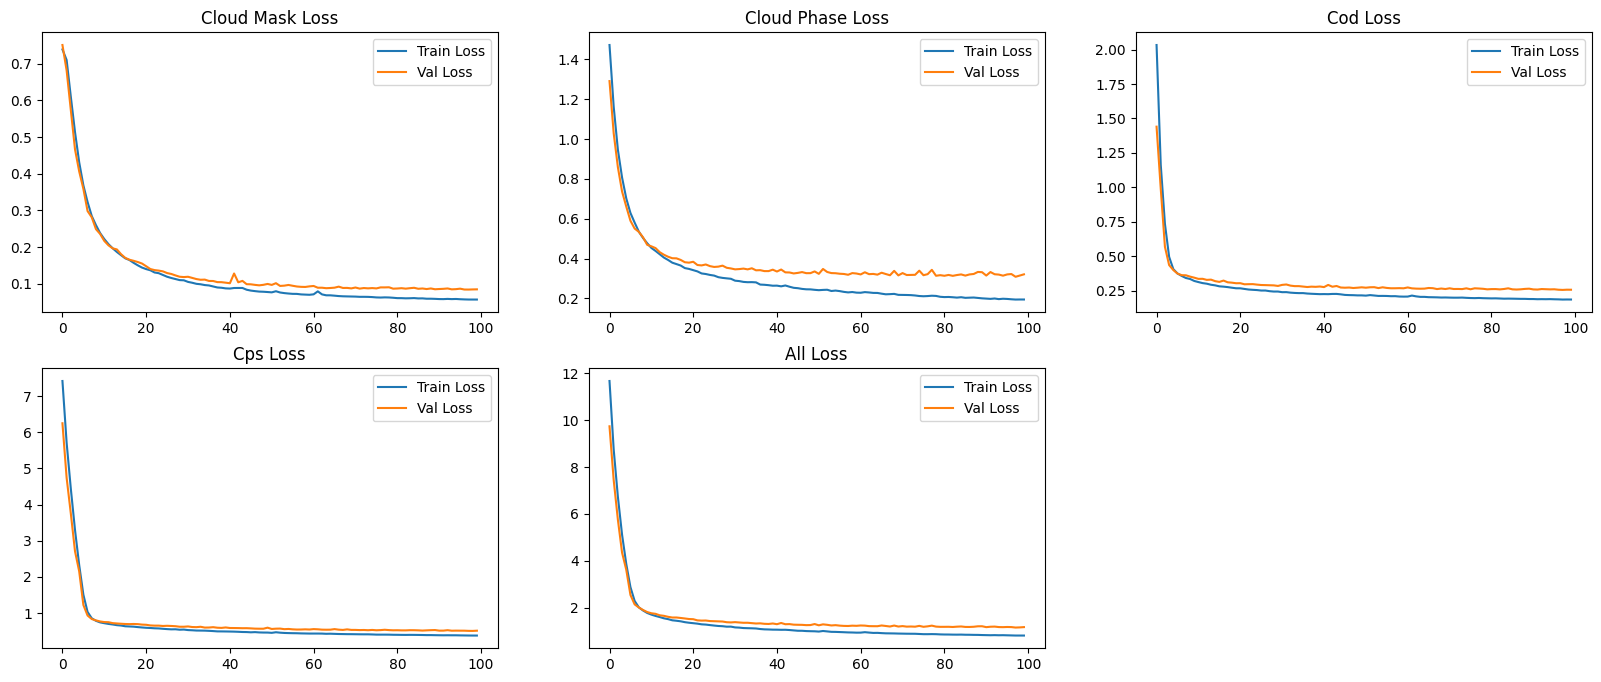

In [9]:
#PLOT LOSS

plt.figure(figsize=(20,8))

plt.subplot(2, 3, 1)
plt.plot(train_mask_losses, label='Train Loss')
plt.plot(val_mask_losses, label='Val Loss')
plt.title('Cloud Mask Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(train_phase_losses, label='Train Loss')
plt.plot(val_phase_losses, label='Val Loss')
plt.title('Cloud Phase Loss')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(train_cod_losses, label='Train Loss')
plt.plot(val_cod_losses, label='Val Loss')
plt.title('Cod Loss')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(train_cps_losses, label='Train Loss')
plt.plot(val_cps_losses, label='Val Loss')
plt.title('Cps Loss')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(train_all_losses, label='Train Loss')
plt.plot(val_all_losses, label='Val Loss')
plt.title('All Loss')
plt.legend()

plt.savefig("./graphs/MultiTaskV3.1_loss.png")  

plt.show()

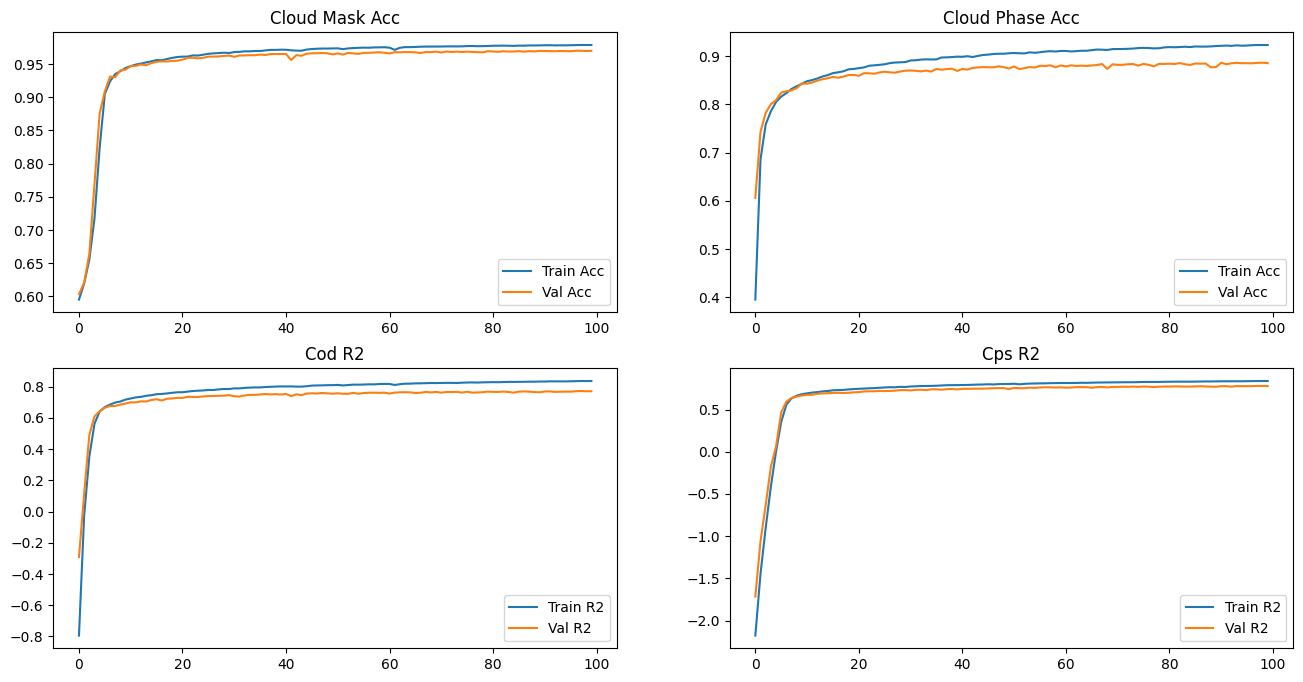

In [10]:
#PLOT ACCURACY

plt.figure(figsize=(16,8))

plt.subplot(2, 2, 1)
plt.plot(train_mask_acc, label='Train Acc')
plt.plot(val_mask_acc, label='Val Acc')
plt.title('Cloud Mask Acc')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_phase_acc, label='Train Acc')
plt.plot(val_phase_acc, label='Val Acc')
plt.title('Cloud Phase Acc')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_cod_r2, label='Train R2')
plt.plot(val_cod_r2, label='Val R2')
plt.title('Cod R2')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_cps_r2, label='Train R2')
plt.plot(val_cps_r2, label='Val R2')
plt.title('Cps R2')
plt.legend()

plt.savefig("./graphs/MultiTaskV3.1_acc.png")  

plt.show()


In [11]:
# MODEL EVALUATION — CLOUD MASK

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        cloud_mask_target, _, _, _ = unpack_labels(labels)
        cloud_mask_pred, _, _, _ = model(images)

        probs = torch.sigmoid(cloud_mask_pred)
        preds = (probs > 0.5).long()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_mask_target.cpu().numpy())

# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(
    all_labels, all_preds,
    labels=[0, 1],
    digits=3,
    output_dict=True,
    zero_division=0
)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(2)])
supports = np.array([report[str(i)]['support'] for i in range(2)])
iou = f1_scores / (2 - f1_scores)


# Output
print("CLOUD MASK REPORT:\n", classification_report(all_labels, all_preds, labels=[0, 1], digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds, labels=[0, 1]))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))

100%|██████████| 12/12 [00:02<00:00,  5.63it/s]


CLOUD MASK REPORT:
               precision    recall  f1-score   support

           0      0.934     0.929     0.931   5803166
           1      0.978     0.980     0.979  18740066

    accuracy                          0.968  24543232
   macro avg      0.956     0.954     0.955  24543232
weighted avg      0.968     0.968     0.968  24543232

CONFUSION MATRIX:
 [[ 5389688   413478]
 [  380642 18359424]]

IOU: [0.87158075 0.95853927]
Unweighted IoU: 0.9150600066436403
Weighted IoU: 0.9379782117765104


In [12]:
# MODEL EVALUATION — CLOUD PHASE

num_classes = 5

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        _, cloud_phase_target, _, _ = unpack_labels(labels)
        _, cloud_phase_pred, _, _ = model(images)
        preds = torch.argmax(cloud_phase_pred, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_phase_target.cpu().numpy())
        
# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(num_classes)])
supports = np.array([report[str(i)]['support'] for i in range(num_classes)])
iou = f1_scores / (2 - f1_scores)

# Output
print("CLOUD PHASE REPORT:\n", classification_report(all_labels, all_preds, digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))


100%|██████████| 12/12 [00:01<00:00,  6.43it/s]


CLOUD PHASE REPORT:
               precision    recall  f1-score   support

           0      0.889     0.917     0.902   4373397
           1      0.900     0.923     0.911  10864796
           2      0.775     0.859     0.815   2400565
           3      0.568     0.444     0.499    890044
           4      0.928     0.853     0.889   6014430

    accuracy                          0.881  24543232
   macro avg      0.812     0.799     0.803  24543232
weighted avg      0.880     0.881     0.880  24543232

CONFUSION MATRIX:
 [[ 4008472   316149    20053     3960    24763]
 [  435069 10030679   179944    13397   205707]
 [    4482   221042  2061742    79020    34279]
 [     773    64153   296961   395330   132827]
 [   61238   518300   100176   203905  5130811]]

IOU: [0.82225758 0.83697519 0.68777486 0.3321191  0.80018812]
Unweighted IoU: 0.6958629698432879
Weighted IoU: 0.7924362960315154


In [13]:
# MODEL EVALUATION — CLOUD OPTICAL DISTANCE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, cod_target, _ = unpack_labels(labels)
        _, _, cod_pred, _ = model(images)
        
        all_preds.append(cod_pred.cpu().numpy().reshape(-1))
        all_labels.append(cod_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:02<00:00,  5.95it/s]


r2: 0.7694043517112732
MSE: 0.2654716968536377


In [14]:
# MODEL EVALUATION — CLOUD PARTICLE SIZE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, _, cps_target = unpack_labels(labels)
        _, _, _, cps_pred = model(images)
        
        all_preds.append(cps_pred.cpu().numpy().reshape(-1))
        all_labels.append(cps_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00,  6.81it/s]


r2: 0.7813034057617188
MSE: 0.5253880620002747


In [ ]:
# my_image = images[0].cpu().numpy()
# my_image = np.transpose(my_image, (1, 2, 0))
# phase_pred = preds[0].cpu().numpy()
# phase_target = cloud_phase_target[0].cpu().numpy()



# from netCDF4 import Dataset
# import numpy as np


# with Dataset('./maps/image1.nc', 'w', format='NETCDF4') as ds:
#     ds.createDimension('x', my_image.shape[0])
#     ds.createDimension('y', my_image.shape[1])
#     ds.createDimension('band', my_image.shape[2])

#     var = ds.createVariable('radiance', 'f4', ('x', 'y', 'band'))
#     var[:] = my_image

#     var.units = 'unknown'  # optional metadata

# with Dataset('./maps/image2.nc', 'w', format='NETCDF4') as ds:
#     ds.createDimension('x', phase_pred.shape[0])
#     ds.createDimension('y', phase_pred.shape[1])

#     var = ds.createVariable('prediction', 'f4', ('x', 'y'))
#     var[:] = phase_pred

#     var.units = 'unknown'  # optional metadata


# with Dataset('./maps/image3.nc', 'w', format='NETCDF4') as ds:
#     ds.createDimension('x', phase_target.shape[0])
#     ds.createDimension('y', phase_target.shape[1])

#     var = ds.createVariable('target', 'f4', ('x', 'y'))
#     var[:] = phase_target

#     var.units = 'unknown'  # optional metadata

